In [1]:
%matplotlib inline
import numpy as np
import os
from datavyz import ges as ge

# Simulations with synaptic mechanisms only

The data are generated by looping over:

    - background activity levels
    - seeds for the background activity
    - stimulus intensity (the number of synapses recruited)
    - the stimulus properties (here the seed that shape the random synaptic sequence).

This loop over four conditions is implemented in the bash script: [./bash/BG.sh](./bash/BG.sh)

You can run it with:

> sh bash/BG.sh

## Load population data from individual sims (seeds & bg-levels)

In [346]:
%run bash/load_batch_simulations.py
RESP_PASSIVE = build_full_dataset(key='passive',
                                  folder = os.path.join('data', 'bg-modul'),
                                  # folder = 'D:',
                                  filename_only=True)

<Figure size 432x288 with 0 Axes>

In [250]:
# plotting function in script:
%run plots/plot_single_sim_bg_data.py

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

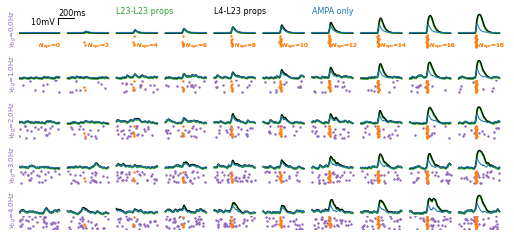

In [372]:
%run plots/plot_single_sim_bg_data.py
props = {'NSTIMs':None,
         'alphaZn':[0.45, 0.45],
         'syn_location':3, 'stimseeds':[0], 'seeds':[0],
         'with_ampa_only':True,
         'LWS':[2,1,1], 'COLORS':[ge.green, 'k'],
         'LABELS':['L23-L23 props', 'L4-L23 props', 'AMPA only'],
         'bar_scale_args':dict(Xbar = 200, Xbar_label='200ms', Ybar = 10, Ybar_label='10mV ', loc=(0.08,0.6), orientation='right-bottom'),
         'figsize':(2.8,.1), 'view':[-200,300], 'shift':100, 'VLIM':[-76,-30]}
fig = plot_single_sim_bg_data(RESP_PASSIVE, ge,
                              bg_levels=[0,1,2,3,4], **props)
fig.savefig(os.path.join('figures', 'bg-dep-passive-full-example-single-trial.png'), dpi=300)

In [266]:
%run bash/load_batch_simulations.py
RESP_PASSIVE_PER_STIM = build_full_dataset_per_stim(key='passive',
                                                    with_Vm_trace=True,
                                                    folder = os.path.join('data', 'bg-modul'),
                                                    # folder='D:',
                                                    filename_only=True)

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

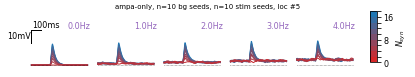

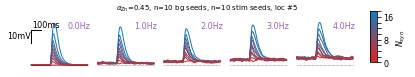

In [333]:
%run plots/show_trial_average_responses.py
props = {'VLIM':[-76,-40], 'syn_location':5}
show_trial_average_responses(RESP_PASSIVE_PER_STIM, 'ampa-only', **props)
show_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0.45, **props)
#show_trial_average_responses(RESP_PASSIVE_PER_STIM, alphaZn=0., **props)

2


C:\Users\yann.zerlaut\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx


2


<Figure size 432x288 with 0 Axes>

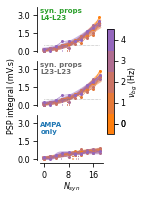

In [375]:
%run plots/show_trial_average_responses.py
props = {'syn_location':2, 'thresholds':{'Proba':0.5}} # 'VLIM':[-76,0], 
AMPA = get_trial_average_responses(RESP_PASSIVE_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PASSIVE_PER_STIM,  alphaZn=0.45, **props)
#CHELATED = get_trial_average_responses(RESP_PASSIVE_PER_STIM,  alphaZn=0., **props)
fig_BG12 = show_response_bg_dep(FREE, FREE, AMPA, method='Integral', ge=ge,
                                ylim=[-0.1,3.7],
                                # xlim=[0,19],
                                # BG_levels=[0,1.,2,3.],
                                crossing=props['thresholds']['Proba'])#.savefig('figures/fig22.svg')
fig_BG12.savefig(os.path.join('figures', 'passive-bg-dep.png'), dpi=300)

# Simulations with active mechanisms (spikes, Ca-dynamics, ...)

The data are generated by looping over:

    - background activity levels
    - seeds for the background activity
    - stimulus intensity (the number of synapses recruited)
    - the stimulus properties (here the seed that shape the random synaptic sequence).

This loop over four conditions is implemented in the bash script: [./bash/BG.sh](./bash/BG.sh)

You can run it with:

> sh bash/BG-active.sh

In [ ]:
%run bash/load_batch_simulations.py
RESP_ACTIVE = build_full_dataset(key='active',
                                 folder = os.path.join('data', 'bg-modul'),
                                 filename_only=True)

<Figure size 432x288 with 0 Axes>

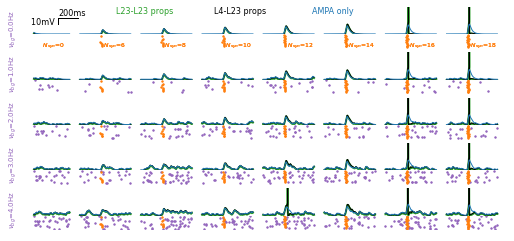

In [373]:
%run plots/plot_single_sim_bg_data.py
# from datavyz import graph_env_dark_notebook as ge
# props = {'NSTIMs':None,#[0, 6, 8, 10, 12, 14],
#          'alphaZn':[0.45, 0.45],
#          'syn_location':5, 'stimseeds':[0], 'figsize':(2.5,.1), 'view':[-300,450], 'shift':100}

%run plots/plot_single_sim_bg_data.py
props = {'NSTIMs':None,
         'alphaZn':[0.45, 0.45],
         'syn_location':5, 'stimseeds':[0], 'seeds':[0],
         'with_ampa_only':True,
         'LWS':[2,1,1], 'COLORS':[ge.green, 'k'],
         'LABELS':['L23-L23 props', 'L4-L23 props', 'AMPA only'],
         'bar_scale_args':dict(Xbar = 200, Xbar_label='200ms', Ybar = 10, Ybar_label='10mV ', loc=(0.08,0.6), orientation='right-bottom'),
         'figsize':(2.8,.1), 'view':[-200,300], 'shift':100, 'VLIM':[-76,-30]}

fig = plot_single_sim_bg_data(RESP_ACTIVE, ge, bg_levels=[0.,1,2,3,4], **props)
fig.savefig(os.path.join('figures', 'bg-dep-active-full-example-single-trial.png'), dpi=300)

In [ ]:
%run bash/load_batch_simulations.py
RESP_ACTIVE_PER_STIM = build_full_dataset_per_stim(key='active',
                                                   with_Vm_trace=True,
                                                   folder = os.path.join('data', 'bg-modul'),
                                                   # folder='D:',
                                                   filename_only=True)


5
5


C:\Users\yann.zerlaut\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\yann.zerlaut\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\yann.zerlaut\Anaconda3\lib\site-packages\scipy\optimize\lbfgsb.py:293: RuntimeWarning: invalid value encountered in greater
  if (new_bounds[0] > new_bounds[1]).any():
C:\Users\yann.zerlaut\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:390: RuntimeWarning: invalid value encountered in less
  if np.any((x0 < lb) | (x0 > ub)):
C:\Users\yann.zerlaut\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:390: RuntimeWarning: invalid value encountered in greater
  if np.any((x0 < lb) | (x0 > ub)):
C:\Users\yann.zerlaut\Anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:405: RuntimeWarning: invalid value encountered in greater_equa

<Figure size 432x288 with 0 Axes>

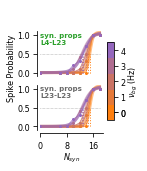

In [345]:
%run plots/show_trial_average_responses.py
props = {'syn_location':5, 'thresholds':{'Proba':0.5}} # 'VLIM':[-76,0], 
FREE = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                   alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_ACTIVE_PER_STIM,
                                       alphaZn=0., **props)
fig_BG12 = show_response_bg_dep(FREE, FREE, method='Proba', ge=ge,
                                ylim=[-0.1,1.1], xlim=[0,19],
                                # BG_levels=[0,1.,2,3.],
                                crossing=props['thresholds']['Proba'])#.savefig('figures/fig22.svg')

C:\Users\yann.zerlaut\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\yann.zerlaut\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\yann.zerlaut\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\yann.zerlaut\Anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


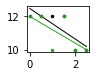

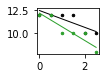

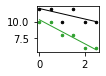

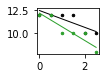

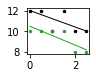

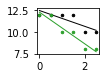

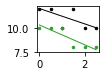

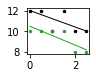

In [11]:
WITH_PLOT = True
SLOPES = {'free':[], 'chelated':[]}
for i in range(25):
    try:
        props = {'syn_location':i, 'thresholds':{'Proba':0.5}} # 'VLIM':[-76,0], 
        FREE = get_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
        CHELATED = get_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)
        if WITH_PLOT:
            fig, ax= ge.figure()
        for C, color, key in zip([FREE, CHELATED], ['k', ge.green], ['free', 'chelated']):
            x = [C[i]['bg_level'] for i in range(len(C))]
            y = [C[i]['Proba-threshold'] for i in range(len(C))]
            lin = np.polyfit(x, y, 1)
            SLOPES[key].append(-lin[0])
            if WITH_PLOT:
                ge.scatter(x, y, color=color, ax=ax, no_set=True)
                ge.plot(x, np.polyval(lin, x), color=color, ax=ax, no_set=True)
    except IndexError:
        pass

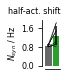

In [12]:
Fig2inset, ax, pval = ge.related_samples_two_conditions_comparison(np.array(SLOPES['free']),
                                                                   np.array(SLOPES['chelated']),
                                                                   with_annotation=False,
                                                                   lw=.5,
                                                                   color1=ge.dimgrey, color2=ge.green,
                                                                   ylabel='$N_{syn}$ / Hz',
                                                                   xticks=[],#[0, 1],
                                                                   fig_args=dict(right=4., figsize=(.5,1.), left=1.2, top=1.5))
ge.annotate(ax, 'half-act. shift', (1., 1.1), ha='right')
Fig2inset.savefig('figures/fig22.svg')

In [142]:
def show_trial_average_responses(RESP_PER_STIM, resp='', 
                                 alphaZn=0., 
                                 VLIM=None,
                                 syn_location='all',
                                 window=[-200,400]):

    if resp=='ampa-only':
        cond = (RESP_PER_STIM['ampa_only']==True)
    else:
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==alphaZn)
        resp = '$\\alpha_{Zn}$=%.2f' % alphaZn
    if syn_location is not 'all':
        cond = cond & (RESP_PER_STIM['syn_location']==syn_location)
        sloc = 'loc #%i' % syn_location
    else:
        sloc = 'Nloc=%i' % len(np.unique(RESP_PER_STIM['syn_location']))
        
    bg_levels = np.unique(RESP_PER_STIM['bg_level'])
    fig, AX = ge.figure(axes=(len(bg_levels),1), wspace=0.1, right=1.3)
    
    fig.suptitle('%s, n=%i bg seeds, n=%i stim seeds, %s' % (resp,
                                                    len(np.unique(RESP_PER_STIM['seed'])),
                                                    len(np.unique(RESP_PER_STIM['seed'])), # STIM SEED HERE !
                                                    sloc))
    t = RESP_PER_STIM['t']
    ylim, ylim2 = [np.inf, -np.inf], [np.inf, -np.inf]
    for ibg, bg in enumerate(bg_levels):
        for istim, nstim in enumerate(np.unique(RESP_PER_STIM['nstim'])[::-1]):
            # raw responses
            scond = cond &\
                (RESP_PER_STIM['nstim']==nstim) & (RESP_PER_STIM['bg_level']==bg)
    
            tcond = (t>=RESP_PER_STIM['stim_delay']+window[0]) & (t<RESP_PER_STIM['stim_delay']+window[1])
            y0 = np.mean([RESP_PER_STIM['Vm'][i] for i, s in enumerate(scond) if s], axis=0)
            AX[ibg].plot(t[tcond], y0[tcond],lw=1,
                    color=ge.red_to_blue(1-istim/len(np.unique(RESP_PER_STIM['nstim']))))
            ylim = [-76, max([ylim[1],y0.max()])]
        AX[ibg].plot([t[tcond][0],t[tcond][-1]], -75*np.ones(2), 'k:', lw=0.5)
        ge.annotate(AX[ibg],'%.1fHz'%bg,(1,1),color=ge.purple,ha='right',va='top')
        
    for ibg, bg in enumerate(bg_levels):
        if VLIM is not None:
            ylim = VLIM
        ge.set_plot(AX[ibg], [], ylim=ylim)
    ge.draw_bar_scales(AX[0], Xbar = 200, Xbar_label='200ms',
                              Ybar = 10, Ybar_label='10mV',
                              loc=(0.05,.8), orientation='right-bottom')
    ge.bar_legend(fig, X=np.unique(RESP_PER_STIM['nstim']),
                  bounds=[0, np.unique(RESP_PER_STIM['nstim'])[-1]],
                  ticks_labels=['%i' % x if i%4==0 else '' for i, x in enumerate(np.unique(RESP_PER_STIM['nstim']))],
                  inset=dict(rect=[.999,.4,.016, .5]),
                  colormap=ge.red_to_blue, label='$N_{syn}$')


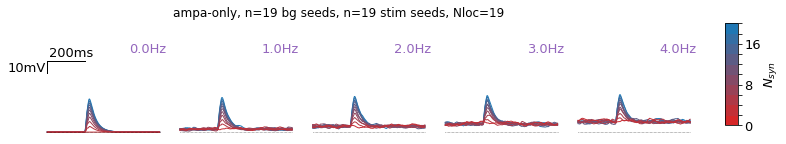

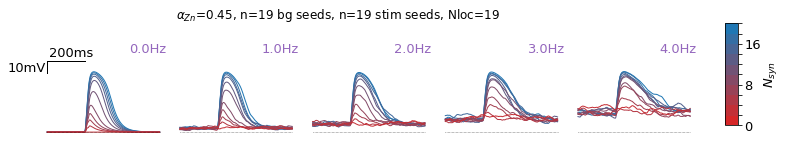

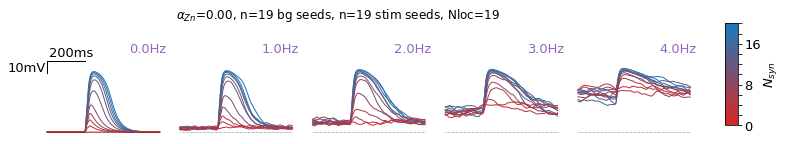

In [143]:
%run plots/show_trial_average_responses.py
props = {'VLIM':[-76,0], 'syn_location':'all'}
show_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
show_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
show_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)

In [144]:
def get_trial_average_responses(RESP_PER_STIM, resp='', 
                                alphaZn=0., 
                                syn_location='all',
                                baseline_window=[-100,0],
                                peak_window=[0,500],
                                integral_window=[0,500]):

    if resp=='ampa-only':
        cond = (RESP_PER_STIM['ampa_only']==True)
    else:
        cond = (RESP_PER_STIM['ampa_only']==False) & (RESP_PER_STIM['alphaZn']==alphaZn)
        resp = '$\\alpha_{Zn}$=%.2f' % alphaZn
    if syn_location is not 'all':
        cond = cond & (RESP_PER_STIM['syn_location']==syn_location)
        sloc = 'loc #%i' % syn_location
    else:
        sloc = 'Nloc=%i' % len(np.unique(RESP_PER_STIM['syn_location']))
        
    bg_levels = np.unique(RESP_PER_STIM['bg_level'])

    t = RESP_PER_STIM['t']

    RESP = []
    
    for ibg, bg in enumerate(bg_levels):
        RESP.append({'nstims':[], 'Peak':[], 'Integral':[], 'Freq':[], 'bg_level':bg})
        for k in ['Peak', 'Integral', 'Freq']:
            RESP[-1][k], RESP[-1]['min'+k], RESP[-1]['max'+k] = [], [], []
            
        for istim, nstim in enumerate(np.unique(RESP_PER_STIM['nstim'])):
           
            RESP[ibg]['nstims'].append(nstim)
            scond = cond &\
                (RESP_PER_STIM['nstim']==nstim) & (RESP_PER_STIM['bg_level']==bg)
            # trial average
            y = np.mean([RESP_PER_STIM['Vm'][i] for i, s in enumerate(scond) if s], axis=0)
            sy = np.std([RESP_PER_STIM['Vm'][i] for i, s in enumerate(scond) if s], axis=0)
            # baseline
            BSLcond = (t>=RESP_PER_STIM['stim_delay']+baseline_window[0]) &\
                            (t<RESP_PER_STIM['stim_delay']+baseline_window[1])
            BSL = np.mean(y[BSLcond])
            # peak depol
            PEAKcond = (t>=RESP_PER_STIM['stim_delay']+peak_window[0]) &\
                            (t<RESP_PER_STIM['stim_delay']+peak_window[1])
            RESP[ibg]['Peak'].append(np.max(y[PEAKcond])-BSL)
            RESP[ibg]['minPeak'].append(np.max(y[PEAKcond]-sy[PEAKcond])-BSL)
            RESP[ibg]['maxPeak'].append(np.max(y[PEAKcond]+sy[PEAKcond])-BSL)
            # depol integral
            INTcond = (t>=RESP_PER_STIM['stim_delay']+integral_window[0]) &\
                            (t<RESP_PER_STIM['stim_delay']+integral_window[1])
            RESP[ibg]['Integral'].append(np.trapz(y[INTcond]-BSL, t[INTcond])/1e3)
            RESP[ibg]['minIntegral'].append(np.trapz(y[INTcond]-sy[PEAKcond]-BSL, t[INTcond])/1e3)
            RESP[ibg]['maxIntegral'].append(np.trapz(y[INTcond]+sy[PEAKcond]-BSL, t[INTcond])/1e3)
            RESP[ibg]['Freq'].append(np.mean([RESP_PER_STIM['freq'][i] for i, s in enumerate(scond) if s]))
            RESP[ibg]['Proba'].append(np.mean([RESP_PER_STIM['spike'][i] for i, s in enumerate(scond) if s]))
            RESP[ibg]['minFreq'].append(RESP[ibg]['Freq'][-1]-np.std([RESP_PER_STIM['freq'][i] for i, s in enumerate(scond) if s]))
            RESP[ibg]['maxFreq'].append(RESP[ibg]['Freq'][-1]+np.std([RESP_PER_STIM['freq'][i] for i, s in enumerate(scond) if s]))
       
    return RESP
        
props = {'syn_location':'all'}
AMPA = get_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)

In [ ]:
cmap = ge.blue_to_red #ge.get_linear_colormap(ge.orange, ge.purple)

# to fit
from scipy.optimize import minimize
def sigmoid_func(x, x0=0, sx=1.):
    return 1./(1+np.exp(-(x-x0)/(1e-9+np.abs(sx))))
        
def show_response_bg_dep(FREE, CHELATED, AMPA=None, 
                         method='Integral',
                         BG_levels=None,
                         ylim=None):
    
    if BG_levels is None:
        BG_levels = [R['bg_level'] for R in FREE]
        
    FWHM = {'Free':[], 'Chelated':[], 'Ampa':[]}
            
    fig, AX = ge.figure(axes=(1,2), figsize=(1,1.), hspace=0.3, right=1.5)
    fig2, ax = ge.figure(axes=(1,1), figsize=(1,1.), hspace=0.3, right=1.5)    
    
    i=0
    for ibg, bg in enumerate(BG_levels):
        """
        if bg_cond[ibg]:           
            if method=='peak':
                y0 = output1['peak'][ibg,:,:,:].mean(axis=(0,2))-output1['bsl'][ibg,:,:,:].mean()#axis=(0,2))
                y1 = output2['peak'][ibg,:,:,:].mean(axis=(0,2))-output2['bsl'][ibg,:,:,:].mean()#axis=(0,2))
            if method=='integral':
                y0 = 1e-3*output1['integral'][ibg,:,:,:].mean(axis=(0,2))
                y1 = 1e-3*output2['integral'][ibg,:,:,:].mean(axis=(0,2))
                
                
            for key, y, ax2 in zip(['L23', 'L4'], [y0, y1], AX):
                def to_minimize(coefs):
                    #return np.sum((y-y.max()*sigmoid_func(args['NSTIMs'], coefs[1], coefs[2]))**2)
                    return np.sum((y-y[0]-coefs[0]*sigmoid_func(args['NSTIMs'], coefs[1], coefs[2]))**2)
                res = minimize(to_minimize, [y.max()-y[0], np.mean(args['NSTIMs']), np.std(args['NSTIMs'])],
                              bounds=([0, 1.5*y.max()], [1, args['NSTIMs'][-1]], [1, args['NSTIMs'][-1]]))
                #FWHM[key].append(res.x[1]) # FWHM of fit isn't really good
                xx = np.linspace(0, max(args['NSTIMs']), 100)
                yy = res.x[0]*sigmoid_func(xx, res.x[1], res.x[2])
                i0 = np.argmin((yy.max()/2.-yy)**2)
                FWHM[key].append(xx[i0]) # FWHM of fit isn't really good
                #ax2.plot(args['NSTIMs'], res.x[0]*sigmoid_func(args['NSTIMs'], res.x[1], res.x[2]), ':',
                #        lw=1, color=cmap(i/(len(BG_levels)-1)))
                ax2.plot(np.ones(2)*res.x[1], [0, res.x[0]*sigmoid_func(res.x[1], res.x[1], res.x[2])], ':',
                        lw=1, color=cmap(i/(len(BG_levels)-1)))
        """
                
        if method[:5]=='delta':
            AX[0].plot(FREE[ibg]['nstims'], FREE[ibg][method[5:]]-FREE[ibg][method[5:]][0],
                       lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            AX[1].plot(CHELATED[ibg]['nstims'], CHELATED[ibg][method[5:]]-CHELATED[ibg][method[5:]][0],
                       lw=1, color=cmap(ibg/(len(BG_levels)-1)))
        
        else:
            #AX[0].plot(FREE[ibg]['nstims'], FREE[ibg][method], lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            #AX[1].plot(CHELATED[ibg]['nstims'], CHELATED[ibg][method], lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            ge.plot(FREE[ibg]['nstims'],
                    FREE[ibg][method], 
                    sy=np.array(FREE[ibg]['max'+method])-np.array(FREE[ibg]['min'+method]),
                    ax=AX[0], 
                    lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            ge.plot(CHELATED[ibg]['nstims'],
                    CHELATED[ibg][method], 
                    sy=np.array(CHELATED[ibg]['max'+method])-np.array(CHELATED[ibg]['min'+method]),
                    ax=AX[1], 
                    lw=1, color=cmap(ibg/(len(BG_levels)-1)))
            #print(np.array(FREE[ibg]['max'+method])-np.array(FREE[ibg]['min'+method]))
            #AX[1].plot(CHELATED[ibg]['nstims'], CHELATED[ibg][method], lw=1, color=cmap(ibg/(len(BG_levels)-1)))
        
        
    #ge.scatter(args['bg_levels'], FWHM['L23'], color='dimgrey', ax=ax, ms=3, lw=1, no_set=True)
    #ge.scatter(args['bg_levels'], FWHM['L4'], color=ge.green, ax=ax, ms=3, lw=1, no_set=True)
    
    ge.annotate(AX[0], 'L23-L23 syn.', (0., .95), size='small', color='dimgrey', bold=True)
    ge.annotate(AX[1], 'L4-L23 syn.', (0., .95), size='small', color=ge.green, bold=True)
    
    #if ylim is None:
    #    ylim = [min(ax.get_ylim()[0] for ax in AX), max(ax.get_ylim()[1] for ax in AX)]
        
    if method=='Integral':
        ylabel='PSP integ. (mV.s)'+20*' '
    if method=='Peak':
        ylabel='max. $\delta$ $V_m$ (mV)'+20*' '
    if method=='Freq':
        ylabel='Spike Freq. (Hz) '+20*' '
    if method=='deltaFreq':
        ylabel='$\delta$ Spike Freq. (Hz) '+20*' '
        
    ge.set_plot(AX[0], ['left'], ylabel=ylabel, ylim=ylim)
    ge.set_plot(AX[1], xlabel='$N_{syn}$', ylim=ylim)
    ge.set_plot(ax, xlabel='$\\nu_{bg}$ (Hz)', ylabel='$c_{50}$ ($N_{syn}$)')
    
    ge.bar_legend(fig,
                  X=[0]+BG_levels,
                  bounds=[-BG_levels[1]/2., BG_levels[-1]+BG_levels[1]/2],
                  inset=dict(rect=[.9,.3,.05, .5]),
                  label='$\\nu_{bg}$ (Hz)',
                  colormap=cmap)
    
    return fig, fig2

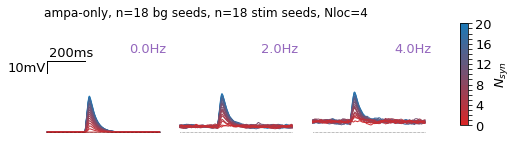

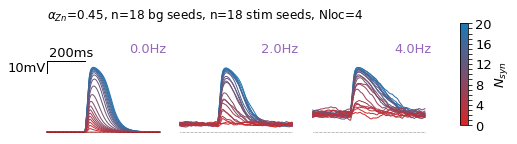

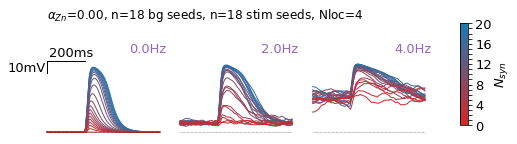

In [41]:
props = {'VLIM':[-76,0], 'syn_location':'all'}
show_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
show_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
show_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)

# Lowering to $\alpha_{Zn}$=0.35

(<Figure size 124.724x155.906 with 3 Axes>,
 <Figure size 124.724x102.047 with 1 Axes>)

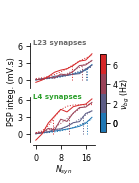

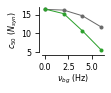

In [12]:
args.alphaZn = 0.35
data_L23_035 = load_dict(filename(args))
output_L23_035 = preprocess_sim(data_L23_035)
show_response_bg_dep(output_L23_035, output_L4, method='integral')

# Lowering to $\alpha_{Zn}$=0.25

(<Figure size 124.724x155.906 with 3 Axes>,
 <Figure size 124.724x102.047 with 1 Axes>)

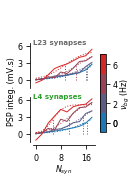

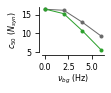

In [13]:
args.alphaZn = 0.25
data_L23_025 = load_dict(filename(args))
output_L23_025 = preprocess_sim(data_L23_025)
show_response_bg_dep(output_L23_025, output_L4, method='integral')

## method based on PSP peak deflection for comparison
--> worse

(<Figure size 124.724x155.906 with 3 Axes>,
 <Figure size 124.724x102.047 with 1 Axes>)

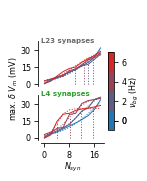

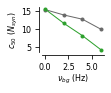

In [14]:
show_response_bg_dep(output_L23, output_L4, method='peak')

# Summary figure

In [394]:
from datavyz import ge
ge.multipanel_figure([['figures/fig_BG12.svg']],
                     LABELS=[['a']],
                     width='double-column', # can also be "single-column" or "one-and-a-half-column"
                     fig_name='figures/Fig_model_Bg-sensitivity.svg',
                     grid=False, # switch to True to get the Grid position and pricesely place labels if necessary
                     export_to_png=True,
                     autoposition=True)

RUNNING: inkscape figures/Fig_model_Bg-sensitivity.svg --export-area-page --export-background="white" --export-type=png --export-filename="figures/Fig_model_Bg-sensitivity.png" --export-dpi=300
[ok] figure successfully exported as: figures/Fig_model_Bg-sensitivity.png


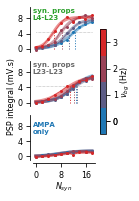

In [351]:
from datavyz import ge
props = {'syn_location':0, 'NSTIMS':np.arange(0, 20, 2), 'integral_window':[0,300]}
AMPA = get_trial_average_responses(RESP_PER_STIM, 'ampa-only', **props)
FREE = get_trial_average_responses(RESP_PER_STIM, alphaZn=0.45, **props)
CHELATED = get_trial_average_responses(RESP_PER_STIM, alphaZn=0., **props)
fig_BG12 = show_response_bg_dep(FREE, CHELATED, AMPA=AMPA, method='Integral', ge=ge,
                                 ylim=[-1,11], BG_levels=[0,1,2,3],crossing=4.5)
fig_BG12.savefig('figures/fig_BG12.svg')